In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras, tfa, tfds:
    print(module.__name__, module.__version__)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.18.4
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0
tensorflow_addons 0.12.0
tensorflow_datasets 4.2.0


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


## Normalization

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                                                    # Number of channels is 1!
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform( x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

## Model with an encoding layer (128-D) as the last layer

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation=None))  # no activation or final dense layer
model.add(keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # L2 normalize embeddings
# model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss=tfa.losses.TripletSemiHardLoss(),
              optimizer = keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 128)        

## Training

In [22]:
history = model.fit(x_train_scaled, y_train,
                    epochs=10,
                    validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5699 - val_loss: 0.3947
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3793 - val_loss: 0.3267
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3198 - val_loss: 0.3026
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2959 - val_loss: 0.2944
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2621 - val_loss: 0.2723
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2382 - val_loss: 0.2747
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2249 - val_loss: 0.2634
Epoch 8/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2051 - val_loss: 0.2404
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1887 - val_loss: 0.2394
Epoch 10/10
1719/1719 [==============================] - 12s 7ms/step - l

## Evaluation

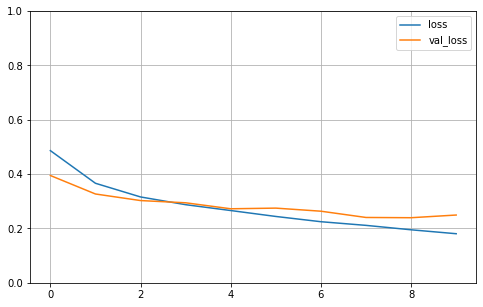

In [23]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [24]:
model.evaluate(x_test_scaled, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.2578


0.2577943503856659

In [27]:
# Get predicted embeddings
results = model.predict(x_test_scaled)
results.shape

(10000, 128)

In [33]:
results[1]

array([ 2.91712815e-03, -8.28091353e-02,  1.51482329e-01, -6.81079999e-02,
       -1.11001737e-01, -8.81426558e-02,  1.25799209e-01,  1.03306007e-02,
       -1.09848388e-01,  8.92175734e-02,  1.15819179e-01,  8.47092345e-02,
        6.52131960e-02,  2.11261772e-02,  9.45342034e-02, -1.44456342e-01,
       -1.20919757e-01,  1.17018279e-02,  1.61377341e-01,  9.83538944e-03,
        4.11930569e-02,  1.16029501e-01,  1.30305141e-01,  1.03107974e-01,
       -3.13420147e-02,  8.01257119e-02, -3.14964801e-02, -1.38359606e-01,
        2.05188915e-02, -1.00090466e-01, -7.46324658e-02, -2.81152856e-02,
        9.48451087e-03,  1.35200843e-01, -5.54289855e-02,  9.80800092e-02,
       -6.76533803e-02, -1.45135447e-01, -3.58197056e-02,  5.46239838e-02,
        2.96264160e-02,  1.56192392e-01,  2.85629816e-02,  1.01510715e-02,
        1.21529981e-01,  9.76254046e-02, -9.84136760e-02, -7.48635828e-02,
       -9.26911773e-04,  1.52414829e-01,  3.38933989e-02, -5.54410042e-03,
        1.66693881e-01,  